In [ ]:
# https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset?resource=download

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emoji

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:
df = pd.read_csv('../datasets/combined_text_emoji_sentiment_dataset.csv')

print(df)
print(f"El dataset tiene {df.shape[0]} filas")
print(f"El dataset tiene {df.isnull().any(axis=1).sum()} filas con valores nulos")
df_clean = df.dropna()
print(f"El dataset tiene {df_clean.isnull().any(axis=1).sum()} filas con valores nulos")

                                               clean_text  category
0       when modi promised “minimum government maximum...      -1.0
1       talk all the nonsense and continue all the dra...       0.0
2       what did just say vote for modi  welcome bjp t...       1.0
3       asking his supporters prefix chowkidar their n...       1.0
4       answer who among these the most powerful world...       1.0
...                                                   ...       ...
164009                                   chart_decreasing      -1.0
164010                                      running_shirt       0.0
164011                                             kimono      -1.0
164012                                       bullet_train      -1.0
164013                                            liberia       1.0

[164014 rows x 2 columns]
El dataset tiene 164014 filas
El dataset tiene 11 filas con valores nulos
El dataset tiene 0 filas con valores nulos


<Axes: xlabel='category'>

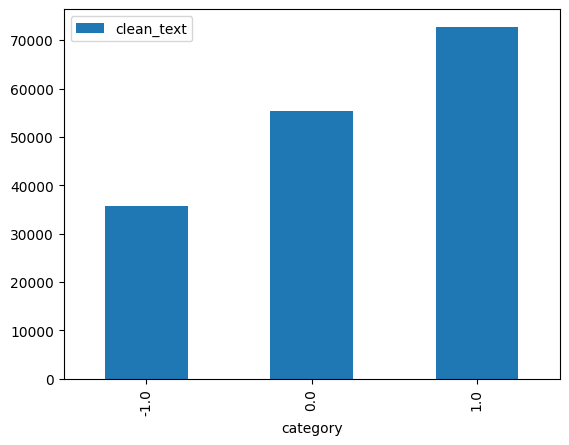

In [4]:
df_clean.groupby('category').count().plot(kind='bar')

C:\Users\hugoc\AppData\Local\Temp\ipykernel_66780\437397031.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['clean_text'] = df_clean['clean_text'].astype(str)


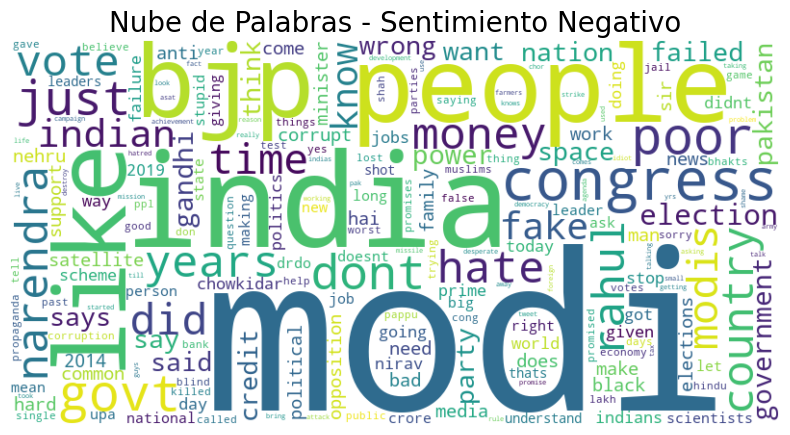

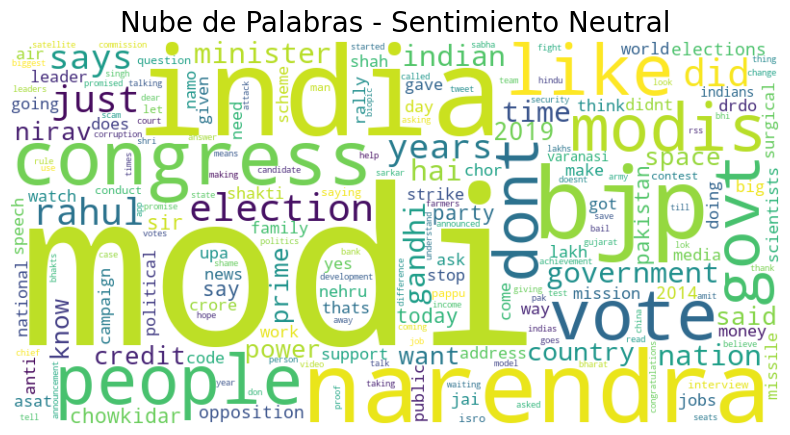

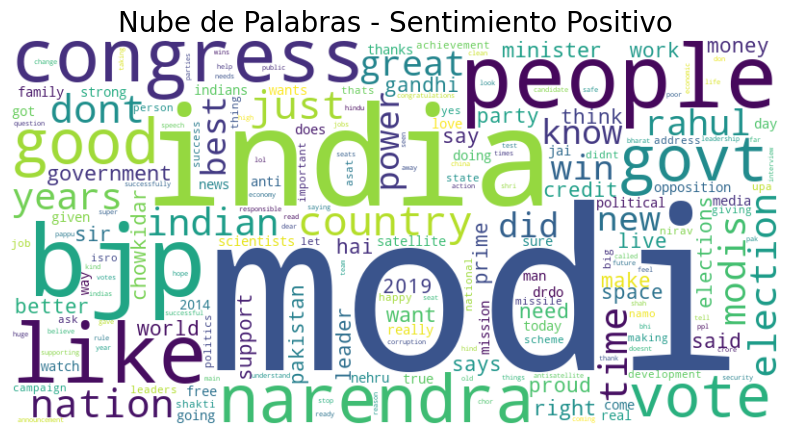

In [5]:

def plot_word_cloud(terms, category):
    # Definir un título basado en el valor de la categoría
    if category == 1.0:
        title = "Positivo"
    elif category == 0.0:
        title = "Neutral"
    else:
        title = "Negativo"
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(terms)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nube de Palabras - Sentimiento {title}', fontsize=20)  # Añadir título aquí
    plt.axis("off")
    plt.show()

# Asegúrate de que los datos están limpios y los textos son strings
df_clean['clean_text'] = df_clean['clean_text'].astype(str)

# Generar nubes de palabras para cada categoría
for category in [-1.0, 0.0, 1.0]:
    subset = df_clean[df_clean['category'] == category]
    texts = " ".join(subset['clean_text'])
    tfidf_vector = TfidfVectorizer(stop_words='english', max_features=1000)
    X_sub = tfidf_vector.fit_transform([texts])
    max_words = {word: X_sub[0, idx] for word, idx in tfidf_vector.vocabulary_.items()}
    plot_word_cloud(max_words, category)  # Pasar también la categoría como argumento


In [6]:
# Tokenización
tokenizer = Tokenizer(num_words=5000)  # Solo considera las 5000 palabras más frecuentes
tokenizer.fit_on_texts(df_clean['clean_text'])
sequences = tokenizer.texts_to_sequences(df_clean['clean_text'])

In [7]:
# Padding
max_sequence_len = max([len(x) for x in sequences])
X = pad_sequences(sequences, maxlen=max_sequence_len)
y = to_categorical(np.asarray(df_clean['category'] + 1))  # Convertir -1, 0, 1 a 0, 1, 2 para categorías

In [8]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_sequence_len),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dense(3, activation='softmax')  # 3 categorías de salida
])

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, batch_size=32, epochs=3, validation_split=0.1)

# Evaluar el modelo
print(model.evaluate(X_train, y_train))


Epoch 1/3


c:\Users\hugoc\anaconda3\envs\thefreeai\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3691/3691 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - accuracy: 0.8095 - loss: 0.4798 - val_accuracy: 0.9473 - val_loss: 0.1908
Epoch 2/3
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9451 - loss: 0.1930 - val_accuracy: 0.9526 - val_loss: 0.1763
Epoch 3/3
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - accuracy: 0.9535 - loss: 0.1668 - val_accuracy: 0.9545 - val_loss: 0.1722
4101/4101 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9593 - loss: 0.1435
[0.14528945088386536, 0.9586668014526367]


In [9]:
# Función para obtener el nombre Unicode de un emoji
def emoji_to_unicode_name(em):
    return emoji.demojize(em)

# Lista de emojis
new_text = '😍😍🤘🤘❤️❤️👄😎😎'

# Convertir la lista a un pandas Series
new_text_series = pd.Series(new_text)

# Aplicar la función a la Series
new_text_unicode_names = new_text_series.apply(emoji_to_unicode_name).str.replace(':',' ')


# Convertir de nuevo a lista si es necesario
new_text = new_text_unicode_names.tolist()

print(new_text)

seq = tokenizer.texts_to_sequences(new_text)
padded = pad_sequences(seq, maxlen=max_sequence_len)

# Realizar la predicción
pred = model.predict(padded)
print(f'Predicción: {pred[0]}')  # Muestra la probabilidad de cada categoría

# Determinar la categoría más probable
predicted_category_index = np.argmax(pred[0])
categories = {-1: 'Negativo', 0: 'Neutral', 1: 'Positivo'}  # Categorías ajustadas para corresponder a tus etiquetas
predicted_category = categories[predicted_category_index - 1]  # ajustar el índice para -1, 0, 1
print(f'La categoría más probable es: {predicted_category} con una probabilidad de {pred[0][predicted_category_index]}')


[' smiling_face_with_heart-eyes  smiling_face_with_heart-eyes  sign_of_the_horns  sign_of_the_horns  red_heart  red_heart  mouth  smiling_face_with_sunglasses  smiling_face_with_sunglasses ']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Predicción: [0.13452677 0.18018013 0.68529314]
La categoría más probable es: Positivo con una probabilidad de 0.6852931380271912
